In [1]:
import numpy as np
train=np.load('./out/tiny_test.npy')
train_mask=np.load('./out/tiny_test_mask.npy')

train = train.astype('float32')
mini = np.min(train)  # mean for data centering
maxi = np.max(train)  # std for data normalization
train -= mini
train /= (maxi -mini)

train_mask = train_mask.astype('float32')
mask_max=np.max(train_mask)
train_mask/=mask_max
# scale masks to [0, 1]
print(train.shape, train_mask.shape)
print(np.min(train), np.max(train), np.min(train_mask),np.max(train_mask))


(100, 96, 96, 1) (100, 96, 96, 1)
0.0 1.0 0.0 1.0


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf


smooth = 1.

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### customized unet loss function in order to ensure sucess and fast training 
def combined_dice_binary_loss(y_true,y_pred):
    def dice_loss(y_true,y_pred):
        numerator= 2 * tf.reduce_sum( y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true +y_pred, axis=(1,2,3))
        return tf.reshape(1-numerator/denominator, (-1,1,1))
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
def get_unet():
    inputs = Input((96, 96, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model
#model=get_unet()
#model.summary()

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
EPOCHS = 201
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=99)
checkpoint_path = "tf_checkpoint/"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    save_best_only=True)

model_history = model.fit(train, train_mask, batch_size=12, epochs=EPOCHS, verbose=1, shuffle=True,validation_data=(train,train_mask),
          callbacks=[cp_callback,early_stopping_callback])

Train on 100 samples, validate on 100 samples
Epoch 1/201
100/100 [==============================] - 14s 139ms/sample - loss: -0.0553 - dice_coef: 0.0549 - val_loss: -0.0554 - val_dice_coef: 0.0555
Epoch 2/201
100/100 [==============================] - 15s 147ms/sample - loss: -0.0554 - dice_coef: 0.0546 - val_loss: -0.0554 - val_dice_coef: 0.0556
Epoch 3/201
100/100 [==============================] - 15s 147ms/sample - loss: -0.0554 - dice_coef: 0.0555 - val_loss: -0.0554 - val_dice_coef: 0.0556
Epoch 4/201
100/100 [==============================] - 18s 183ms/sample - loss: -0.0554 - dice_coef: 0.0556 - val_loss: -0.0555 - val_dice_coef: 0.0556
Epoch 5/201
100/100 [==============================] - 17s 174ms/sample - loss: -0.0555 - dice_coef: 0.0556 - val_loss: -0.0555 - val_dice_coef: 0.0557
Epoch 6/201
100/100 [==============================] - 16s 163ms/sample - loss: -0.0555 - dice_coef: 0.0555 - val_loss: -0.0556 - val_dice_coef: 0.0557
Epoch 7/201
100/100 [=====================

Epoch 29/201
100/100 [==============================] - 18s 176ms/sample - loss: -0.0720 - dice_coef: 0.0729 - val_loss: -0.0766 - val_dice_coef: 0.0770
Epoch 30/201
100/100 [==============================] - 16s 164ms/sample - loss: -0.0796 - dice_coef: 0.0782 - val_loss: -0.0836 - val_dice_coef: 0.0841
Epoch 31/201
100/100 [==============================] - 23s 233ms/sample - loss: -0.0853 - dice_coef: 0.0865 - val_loss: -0.0876 - val_dice_coef: 0.0881
Epoch 32/201
100/100 [==============================] - 19s 187ms/sample - loss: -0.0886 - dice_coef: 0.0882 - val_loss: -0.0891 - val_dice_coef: 0.0896
Epoch 33/201
100/100 [==============================] - 16s 164ms/sample - loss: -0.0904 - dice_coef: 0.0901 - val_loss: -0.0923 - val_dice_coef: 0.0928
Epoch 34/201
100/100 [==============================] - 25s 251ms/sample - loss: -0.0929 - dice_coef: 0.0927 - val_loss: -0.0939 - val_dice_coef: 0.0945
Epoch 35/201
100/100 [==============================] - 18s 185ms/sample - loss: -

100/100 [==============================] - 17s 166ms/sample - loss: -0.5259 - dice_coef: 0.5310 - val_loss: -0.5374 - val_dice_coef: 0.5320
Epoch 64/201
100/100 [==============================] - 23s 229ms/sample - loss: -0.5292 - dice_coef: 0.5220 - val_loss: -0.5095 - val_dice_coef: 0.5048
Epoch 65/201
100/100 [==============================] - 16s 165ms/sample - loss: -0.5263 - dice_coef: 0.5248 - val_loss: -0.5187 - val_dice_coef: 0.5149
Epoch 66/201
100/100 [==============================] - 14s 143ms/sample - loss: -0.5278 - dice_coef: 0.5292 - val_loss: -0.4963 - val_dice_coef: 0.4925
Epoch 67/201
100/100 [==============================] - 13s 135ms/sample - loss: -0.5227 - dice_coef: 0.5207 - val_loss: -0.5305 - val_dice_coef: 0.5271
Epoch 68/201
100/100 [==============================] - 13s 134ms/sample - loss: -0.5363 - dice_coef: 0.5364 - val_loss: -0.5346 - val_dice_coef: 0.5284
Epoch 69/201
100/100 [==============================] - 17s 166ms/sample - loss: -0.5392 - dice

Epoch 106/201
100/100 [==============================] - 22s 222ms/sample - loss: -0.5507 - dice_coef: 0.5615 - val_loss: -0.5520 - val_dice_coef: 0.5461
Epoch 107/201
100/100 [==============================] - 19s 192ms/sample - loss: -0.5539 - dice_coef: 0.5609 - val_loss: -0.5546 - val_dice_coef: 0.5489
Epoch 108/201
100/100 [==============================] - 14s 142ms/sample - loss: -0.5549 - dice_coef: 0.5608 - val_loss: -0.5417 - val_dice_coef: 0.5345
Epoch 109/201
100/100 [==============================] - 18s 175ms/sample - loss: -0.5484 - dice_coef: 0.5398 - val_loss: -0.5567 - val_dice_coef: 0.5512
Epoch 110/201
100/100 [==============================] - 22s 221ms/sample - loss: -0.5468 - dice_coef: 0.5580 - val_loss: -0.5525 - val_dice_coef: 0.5483
Epoch 111/201
100/100 [==============================] - 16s 165ms/sample - loss: -0.5498 - dice_coef: 0.5482 - val_loss: -0.5389 - val_dice_coef: 0.5341
Epoch 112/201
100/100 [==============================] - 17s 175ms/sample - 

Epoch 184/201
100/100 [==============================] - 24s 241ms/sample - loss: -0.6299 - dice_coef: 0.6288 - val_loss: -0.6247 - val_dice_coef: 0.6225
Epoch 185/201
100/100 [==============================] - 17s 172ms/sample - loss: -0.6230 - dice_coef: 0.6288 - val_loss: -0.6057 - val_dice_coef: 0.6050
Epoch 186/201
100/100 [==============================] - 18s 178ms/sample - loss: -0.6243 - dice_coef: 0.6266 - val_loss: -0.6365 - val_dice_coef: 0.6361
Epoch 187/201
100/100 [==============================] - 17s 168ms/sample - loss: -0.6237 - dice_coef: 0.6173 - val_loss: -0.6178 - val_dice_coef: 0.6178
Epoch 188/201
100/100 [==============================] - 16s 155ms/sample - loss: -0.6273 - dice_coef: 0.6265 - val_loss: -0.6315 - val_dice_coef: 0.6314
Epoch 189/201
100/100 [==============================] - 17s 171ms/sample - loss: -0.6397 - dice_coef: 0.6399 - val_loss: -0.6397 - val_dice_coef: 0.6393
Epoch 190/201
100/100 [==============================] - 24s 243ms/sample - 

In [3]:
# Save the weights
#model.save_weights('./my_checkpoint')

# Create a new model instance
m = get_unet()

# Restore the weights
m.load_weights('./my_checkpoint')


In [4]:
print(m.inputs,m.outputs)

for layer in m.layers:
    print(layer.name)


[<tf.Tensor 'input_1:0' shape=(None, 96, 96, 1) dtype=float32>] [<tf.Tensor 'conv2d_18/Identity:0' shape=(None, 96, 96, 1) dtype=float32>]
input_1
conv2d
conv2d_1
max_pooling2d
conv2d_2
conv2d_3
max_pooling2d_1
conv2d_4
conv2d_5
max_pooling2d_2
conv2d_6
conv2d_7
max_pooling2d_3
conv2d_8
conv2d_9
conv2d_transpose
concatenate
conv2d_10
conv2d_11
conv2d_transpose_1
concatenate_1
conv2d_12
conv2d_13
conv2d_transpose_2
concatenate_2
conv2d_14
conv2d_15
conv2d_transpose_3
concatenate_3
conv2d_16
conv2d_17
conv2d_18


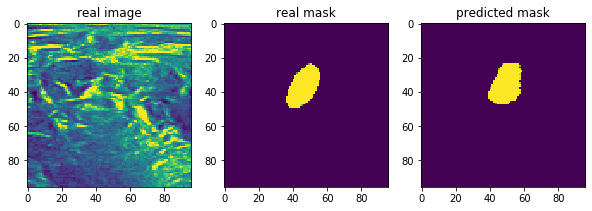

In [5]:
import matplotlib.pyplot as plt
import random
rn=random.randint(0,len(train)-1)
%matplotlib inline
out= m.predict(train[rn].reshape(1,96,96,1))
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(np.squeeze(train[rn]*96))
plt.title('real image')

fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(train_mask[rn]))
plt.title('real mask')


fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(out))
plt.title('predicted mask')

plt.show()


In [11]:
!pip install tf-explain

# visualize with tensorboard using tf-explain

In [28]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


Known TensorBoard instances:
  - port 6006: logdir ./log (started 4 days, 0:04:09 ago; pid 18636)
  - port 6006: logdir logs (started 13:18:09 ago; pid 2620)
  - port 6006: logdir ./log (started 4 days, 0:01:02 ago; pid 8284)


In [ ]:
!tensorboard --logdir=logs --host localhost --port 8088

In [ ]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="model.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [7]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="tensorboard_visualize.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [8]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
#notebook.display(port=6006, height=800)

In [25]:
from tf_explain.callbacks.grad_cam import GradCAMCallback


callbacks = [
    GradCAMCallback(
        validation_data=(train, train_mask),
        layer_name="conv2d_18",
        class_index=1,
        output_dir='./logs',
    )
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

Train on 100 samples
Epoch 1/2
100/100 [==============================] - 15s 149ms/sample - loss: -0.6513 - dice_coef: 0.6513
Epoch 2/2
100/100 [==============================] - 15s 151ms/sample - loss: -0.6367 - dice_coef: 0.6367


In [10]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(train, train_mask),
        layers_name=["conv2d_16"],
        output_dir='./logs',
    ),
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

Train on 100 samples
Epoch 1/2
100/100 [==============================] - 18s 182ms/sample - loss: -0.6205 - dice_coef: 0.6205
Epoch 2/2
100/100 [==============================] - 18s 181ms/sample - loss: -0.6472 - dice_coef: 0.6472


In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

from tf_explain.callbacks.gradients import VanillaGradientsCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.smoothgrad import SmoothGradCallback
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback